In [24]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
df = pd.read_csv("House Price India.csv")

In [26]:
df.head()

,id,Date,number of bedrooms,number of bathrooms,living area,lot area,number of floors,waterfront present,number of views,condition of the house,...,Built Year,Renovation Year,Postal Code,Lattitude,Longitude,living_area_renov,lot_area_renov,Number of schools nearby,Distance from the airport,Price
0,6762810145,42491,5,2.50,3650,9050,2.0,0,4,5,...,1921,0,122003,52.8645,-114.557,2880,5400,2,58,2380000
1,6762810635,42491,4,2.50,2920,4000,1.5,0,0,5,...,1909,0,122004,52.8878,-114.470,2470,4000,2,51,1400000
2,6762810998,42491,5,2.75,2910,9480,1.5,0,0,3,...,1939,0,122004,52.8852,-114.468,2940,6600,1,53,1200000
3,6762812605,42491,4,2.50,3310,42998,2.0,0,0,3,...,2001,0,122005,52.9532,-114.321,3350,42847,3,76,838000
4,6762812919,42491,3,2.00,2710,4500,1.5,0,0,4,...,1929,0,122006,52.9047,-114.485,2060,4500,1,51,805000


In [27]:
df.drop(columns=['id','Date','Postal Code','living_area_renov','lot_area_renov'],inplace=True)

In [28]:
df.drop(columns=['Renovation Year', 'Lattitude', 'Longitude','Area of the house(excluding basement)', 'Area of the basement'],inplace=True)

In [29]:
df.columns

Index(['number of bedrooms', 'number of bathrooms', 'living area', 'lot area',
       'number of floors', 'waterfront present', 'number of views',
       'condition of the house', 'grade of the house', 'Built Year',
       'Number of schools nearby', 'Distance from the airport', 'Price'],
      dtype='object')

In [30]:
df.isnull().sum()

number of bedrooms           0
number of bathrooms          0
living area                  0
lot area                     0
number of floors             0
waterfront present           0
number of views              0
condition of the house       0
grade of the house           0
Built Year                   0
Number of schools nearby     0
Distance from the airport    0
Price                        0
dtype: int64

In [31]:
df['House Age'] = 2025 - df['Built Year']
df.drop(columns=['Built Year'],inplace=True)

In [32]:
print(df.dtypes)

number of bedrooms             int64
number of bathrooms          float64
living area                    int64
lot area                       int64
number of floors             float64
waterfront present             int64
number of views                int64
condition of the house         int64
grade of the house             int64
Number of schools nearby       int64
Distance from the airport      int64
Price                          int64
House Age                      int64
dtype: object


In [43]:
## Removing Outliers (Removes Top 1% outliers)
df = df[df['Price'] < df['Price'].quantile(0.99)]
df = df[df['living area'] < df['living area'].quantile(0.99)]
df = df[df['lot area'] < df['lot area'].quantile(0.99)]

In [44]:
## Feature engineering
df['price_per_sqft'] = df['Price'] / df['living area']

df['lot_utilization_ratio'] = df['living area'] / df['lot area']

df['bath_per_bed'] = df['number of bathrooms'] / df['number of bedrooms']
df['bath_per_bed'] = df['bath_per_bed'].replace([np.inf, -np.inf], 0)
df['bath_per_bed'] = df['bath_per_bed'].fillna(0)

df['schools_per_km'] = df['Number of schools nearby'] / (df['Distance from the airport'] + 1)

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14175 entries, 1 to 14619
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   number of bedrooms         14175 non-null  int64  
 1   number of bathrooms        14175 non-null  float64
 2   living area                14175 non-null  int64  
 3   lot area                   14175 non-null  int64  
 4   number of floors           14175 non-null  float64
 5   waterfront present         14175 non-null  int64  
 6   number of views            14175 non-null  int64  
 7   condition of the house     14175 non-null  int64  
 8   grade of the house         14175 non-null  int64  
 9   Number of schools nearby   14175 non-null  int64  
 10  Distance from the airport  14175 non-null  int64  
 11  Price                      14175 non-null  int64  
 12  House Age                  14175 non-null  int64  
 13  price_per_sqft             14175 non-null  float64


In [72]:
df['log_price'] = np.log1p(df['Price'])

In [76]:
## Independent and Dependent Features
X = df.drop(['Price', 'log_price'], axis=1)
y = df['log_price']

In [77]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

In [78]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=pd.qcut(df['Price'], q=5), random_state=42)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Support Vector Regression (63% Accuracy)

In [68]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

svr = SVR(kernel='rbf', C=1000, epsilon=0.1, gamma='scale')
svr.fit(X_train_scaled, y_train)
y_pred = svr.predict(X_test_scaled)

print("R2 Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R2 Score: 0.630558694056168
MAE: 87902.55639403837
MSE: 28005824245.98965


#### Linear Regression

In [65]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

regression = LinearRegression()
regression.fit(X_train_scaled, y_train)
y_pred = regression.predict(X_test_scaled)

print("R2 Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R2 Score: 0.9154321274089435
MAE: 51597.45490396328
MSE: 6410742216.796007


### Random Forest Regressor (99% Accuracy)

In [88]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
print("R²:", rf.score(X_test, y_test))
print("Train R²:", rf.score(X_train, y_train))
print("Test R²:", rf.score(X_test, y_test))

R²: 0.9989530832419448
Train R²: 0.9998410793427348
Test R²: 0.9989530832419448


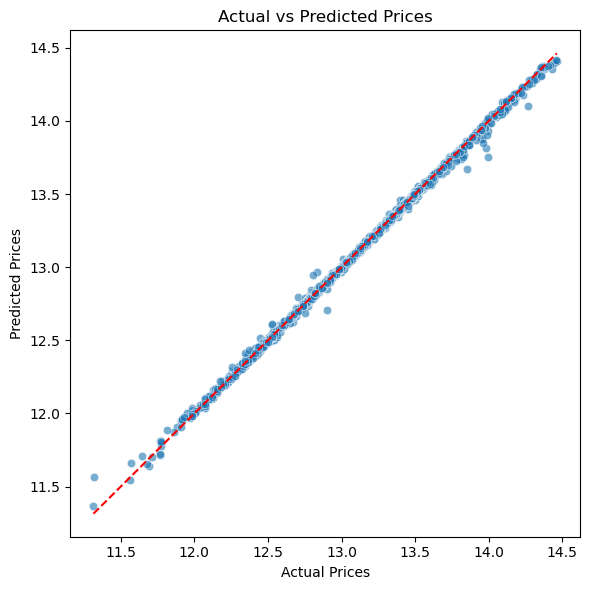

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = rf.predict(X_test)

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.tight_layout()
plt.show()

In [90]:
import pickle
with open("house_price_model.pkl", "wb") as f:
    pickle.dump(rf, f)

In [85]:
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)